#Data Loading

In [ ]:
import os
import pandas as pd

# Define paths for ICU and hospital directories
icu_path = 'icuunzipped'
hosp_path = 'hospunzipped'

# Function to read CSV files and print column names
def print_columns_in_directory(directory_path):
    file_columns = {}
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)
            try:
                df = pd.read_csv(file_path, nrows=5)  # Read only a few rows to avoid memory issues
                file_columns[file_name] = list(df.columns)
            except Exception as e:
                file_columns[file_name] = f"Error reading file: {e}"
    return file_columns

# Get column names for ICU and hospital datasets
icu_columns = print_columns_in_directory(icu_path)

hosp_columns = print_columns_in_directory(hosp_path)

print('ICU data')
print(icu_columns)
print('Hosp data')
print(hosp_columns)


ICU data
{'procedureevents.csv': ['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime', 'endtime', 'storetime', 'itemid', 'value', 'valueuom', 'location', 'locationcategory', 'orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription', 'patientweight', 'isopenbag', 'continueinnextdept', 'statusdescription', 'ORIGINALAMOUNT', 'ORIGINALRATE'], 'datetimeevents.csv': ['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'charttime', 'storetime', 'itemid', 'value', 'valueuom', 'warning'], 'd_items.csv': ['itemid', 'label', 'abbreviation', 'linksto', 'category', 'unitname', 'param_type', 'lownormalvalue', 'highnormalvalue'], 'caregiver.csv': ['caregiver_id'], 'inputevents.csv': ['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime', 'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate', 'rateuom', 'orderid', 'linkorderid', 'ordercategoryname', 'secondaryordercategoryname', 'ordercomponenttypedescription', 'ordercategorydescription', 'patientweight'

In [ ]:
import pandas as pd

#load datasets
datetimeevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/datetimeevents.csv')
chartevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/chartevents.csv')
labevents = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/labevents.csv')
d_items = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/icuunzipped/d_items.csv')
d_labitems = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/d_labitems.csv')
admissions = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/admissions.csv')
patients = pd.read_csv('/mmfs1/project/mx6/sp3463/MIMIC-IV/hospunzipped/patients.csv')

#join labevents with d_labitems for labels
labevents_with_metadata = labevents.merge(d_labitems, on='itemid', how='left')

print(labevents_with_metadata)

print("Number of columns in Admissions: ", len(labevents_with_metadata))

missing_values = labevents_with_metadata.isnull().sum()
print("Missing Values:")
print(missing_values)

        labevent_id  subject_id     hadm_id  specimen_id  itemid  \
0            172061    10014354  29600294.0      1808066   51277   
1            172062    10014354  29600294.0      1808066   51279   
2            172068    10014354  29600294.0      1808066   52172   
3            172063    10014354  29600294.0      1808066   51301   
4            172050    10014354  29600294.0      1808066   51249   
...             ...         ...         ...          ...     ...   
107722       254700    10021487  28998349.0     78791160   50804   
107723       254702    10021487  28998349.0     78791160   50818   
107724       254707    10021487  28998349.0     78791160   52033   
107725       254706    10021487  28998349.0     78791160   50825   
107726       454886    10038999  27189241.0     13534028   50873   

       order_provider_id            charttime            storetime value  \
0                    NaN  2148-08-16 00:00:00  2148-08-16 01:30:00  15.4   
1                    NaN  2148-

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

#filter relevant vitals from chartevents using d_items
relevant_items = d_items[d_items['label'].str.contains('heart rate|blood pressure|temperature', case=False)]
filtered_chartevents = chartevents[chartevents['itemid'].isin(relevant_items['itemid'])]

#join with metadata for labels
filtered_chartevents = filtered_chartevents.merge(d_items[['itemid', 'label']], on='itemid', how='left')

#join with patient and admission details
chartevents_with_context = filtered_chartevents.merge(admissions, on=['subject_id', 'hadm_id'], how='left')
chartevents_with_context = chartevents_with_context.merge(patients, on='subject_id', how='left')

#select relevant columns
vitals_data = chartevents_with_context[['subject_id', 'hadm_id', 'label', 'valuenum', 'valueuom', 'gender', 'anchor_age', 'admission_type']]

missing_values = vitals_data.isnull().sum()
print("Length of dataset: ", len(vitals_data))
print("Missing Values:")
print(missing_values)

print("Missing percentage:")
#calculate missing percentages for each column
missing_percentage = vitals_data.isnull().mean() * 100
print(missing_percentage)

Length of dataset:  70413
Missing Values:
subject_id           0
hadm_id              0
label                0
valuenum          5816
valueuom          5816
gender               0
anchor_age           0
admission_type       0
dtype: int64
Missing percentage:
subject_id        0.000000
hadm_id           0.000000
label             0.000000
valuenum          8.259838
valueuom          8.259838
gender            0.000000
anchor_age        0.000000
admission_type    0.000000
dtype: float64


In [ ]:
vitals_data

,subject_id,hadm_id,label,valuenum,valueuom,gender,anchor_age,admission_type
0,10005817,20626031,Heart Rate Alarm - Low,55.0,bpm,M,66,URGENT
1,10005817,20626031,Heart rate Alarm - High,120.0,bpm,M,66,URGENT
2,10005817,20626031,Arterial Blood Pressure diastolic,37.0,mmHg,M,66,URGENT
3,10005817,20626031,Temperature Celsius,37.0,°C,M,66,URGENT
4,10005817,20626031,Arterial Blood Pressure Alarm - High,140.0,mmHg,M,66,URGENT
...,...,...,...,...,...,...,...,...
70408,10019003,29279905,Heart Rate,99.0,bpm,F,65,EW EMER.
70409,10019003,29279905,Temperature Fahrenheit,97.8,°F,F,65,EW EMER.
70410,10019003,29279905,Non Invasive Blood Pressure diastolic,62.0,mmHg,F,65,EW EMER.
70411,10019003,29279905,Non Invasive Blood Pressure systolic,118.0,mmHg,F,65,EW EMER.


In above cell we can see that mostly the columns don't have missing values, but valuenum and valueuom have 5816 missing. However, this is still less than 10% of the data, so rather than dropping the column, we can benefit from imputting this column with mean as this is an important feature and only a small percentage of the record data is missing. However, we need to pivot the data beforehand as the labels in the dataset actually consists of vitals of patients, with each patients having multiple records with their respective labels which are patient's vitals with valuenum being the recording of the vital and valueuom being the measure. Let's first see the distribution of the labels, and then we can convert the label column into independent features via pivotting labels into columns.

##Data Distribution

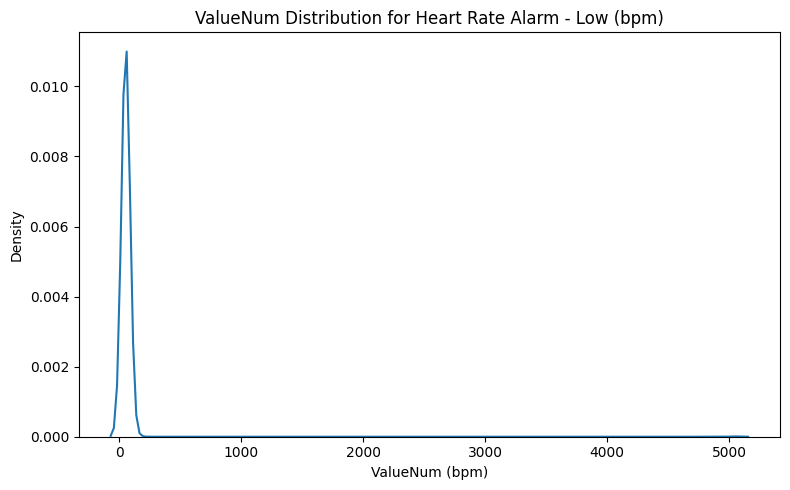

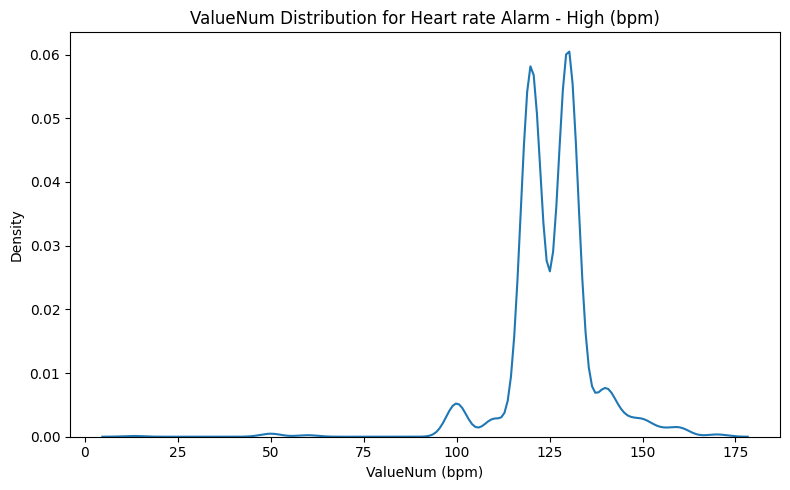

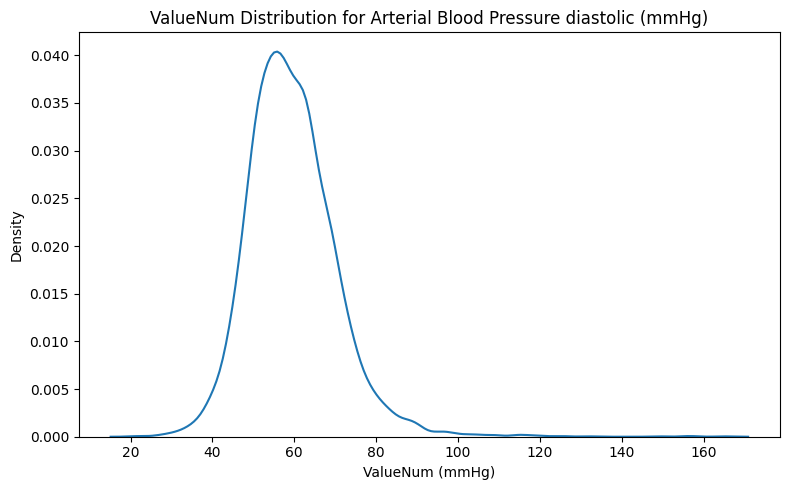

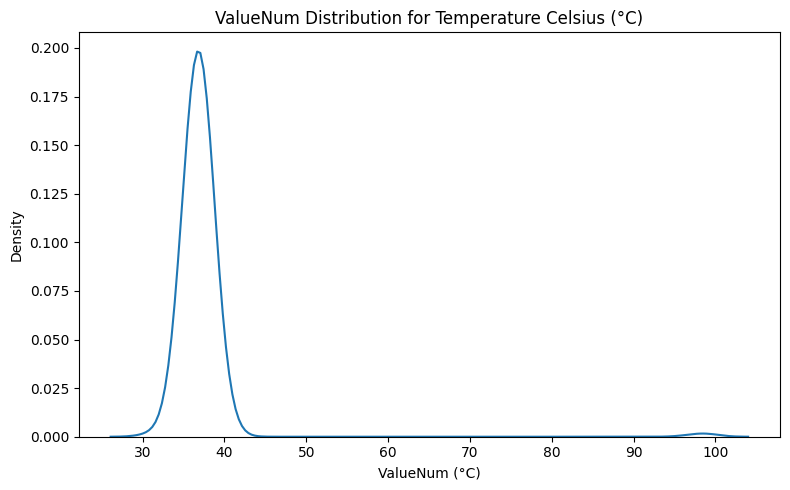

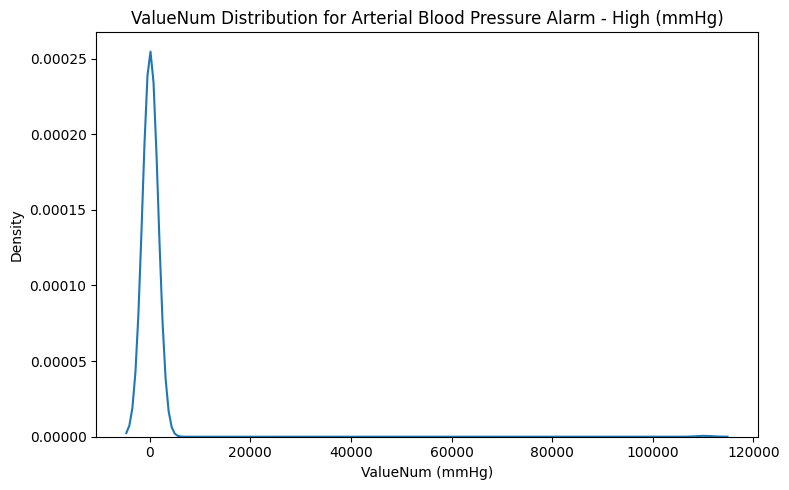

/tmp/ipykernel_2745731/2888883709.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['valuenum'])


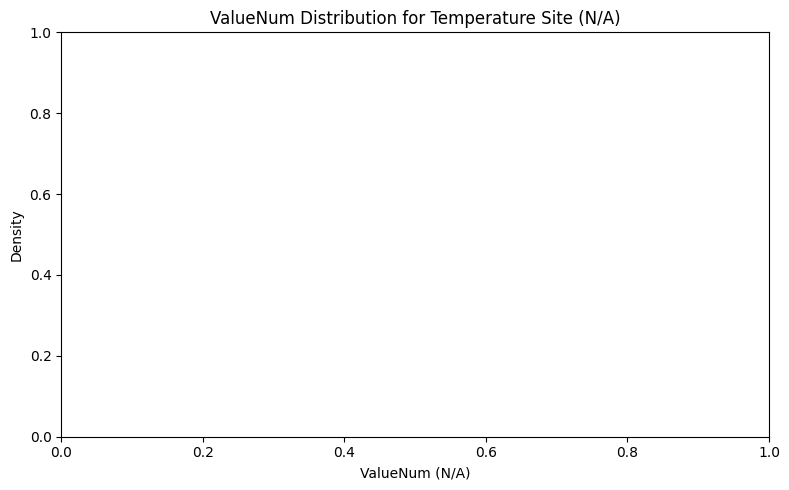

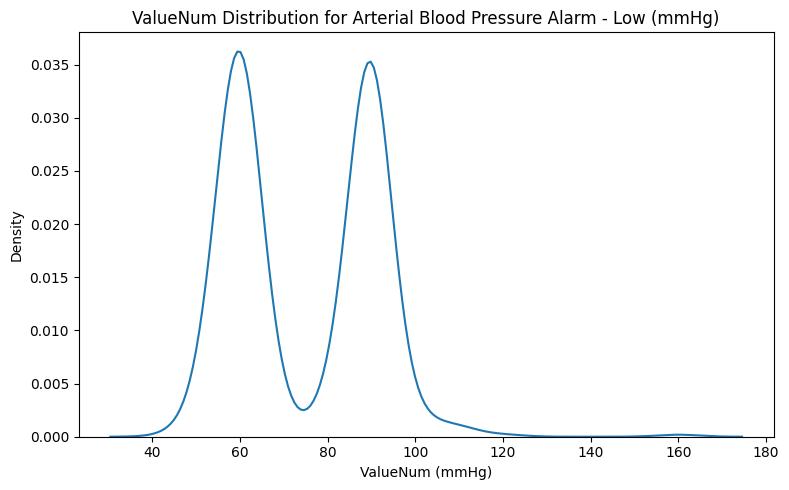

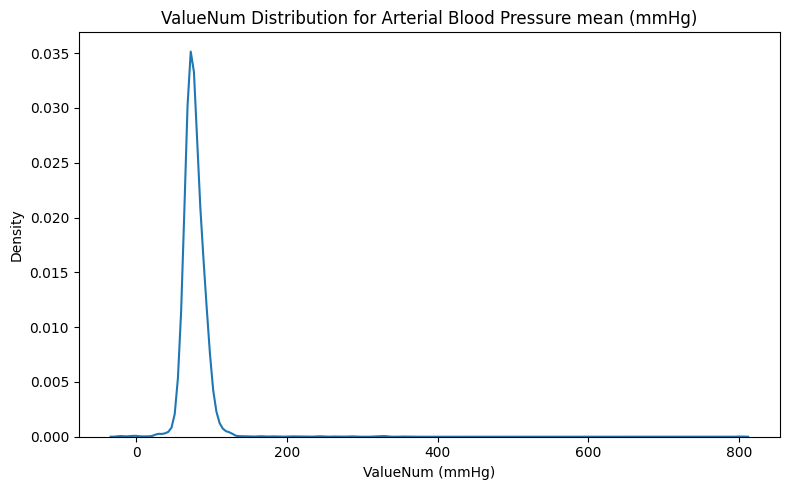

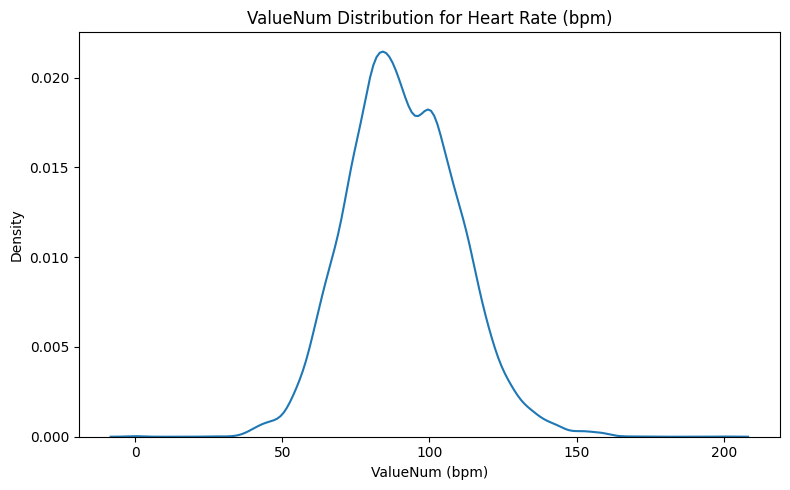

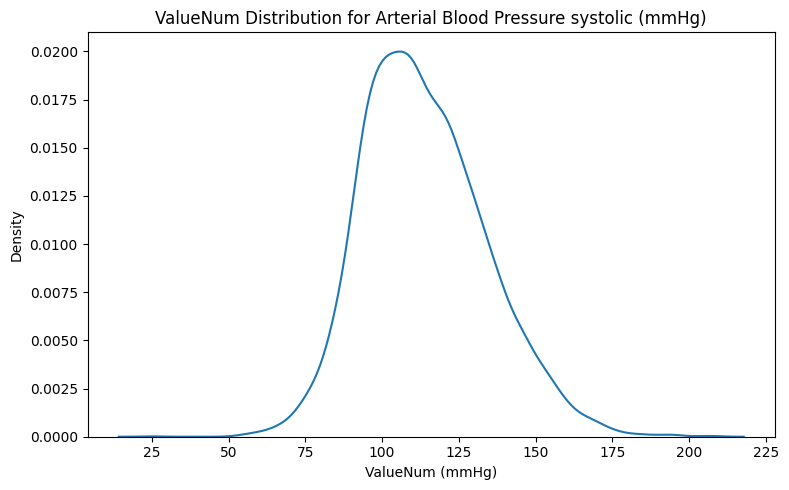

/tmp/ipykernel_2745731/2888883709.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['valuenum'])


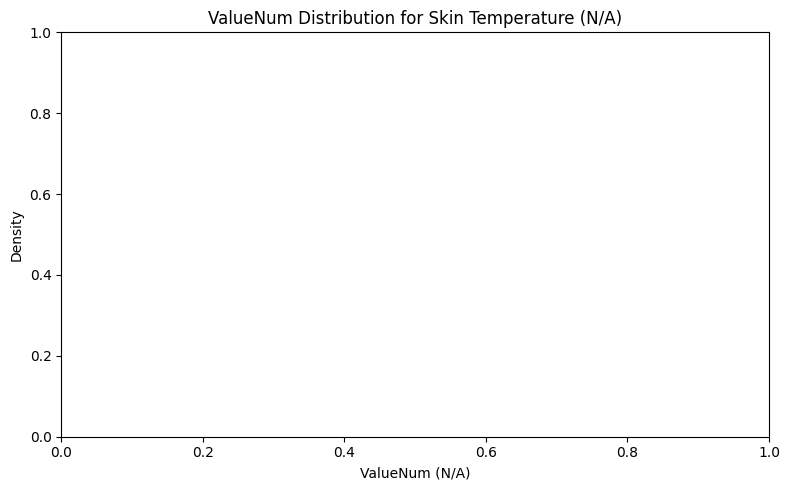

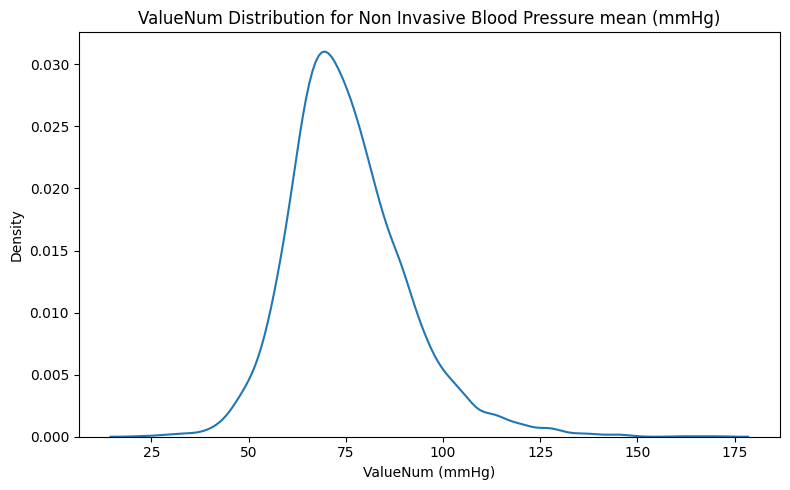

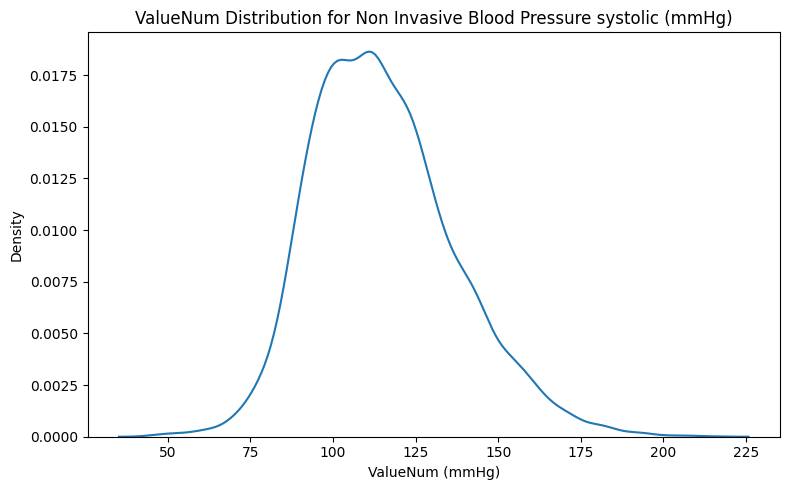

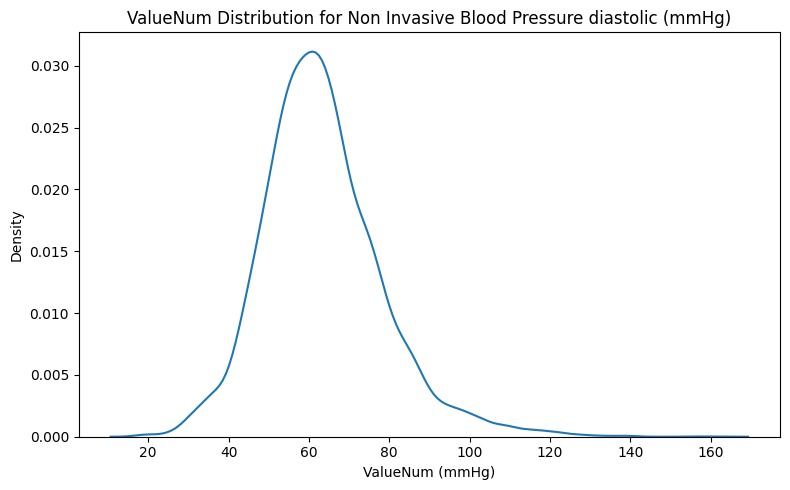

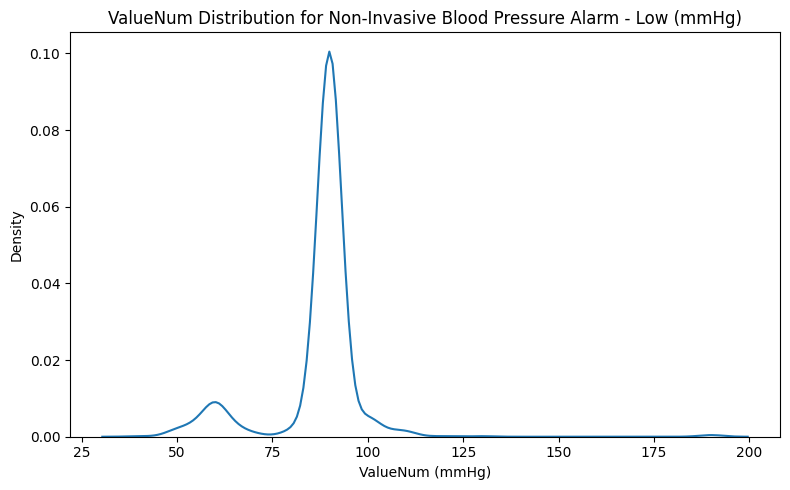

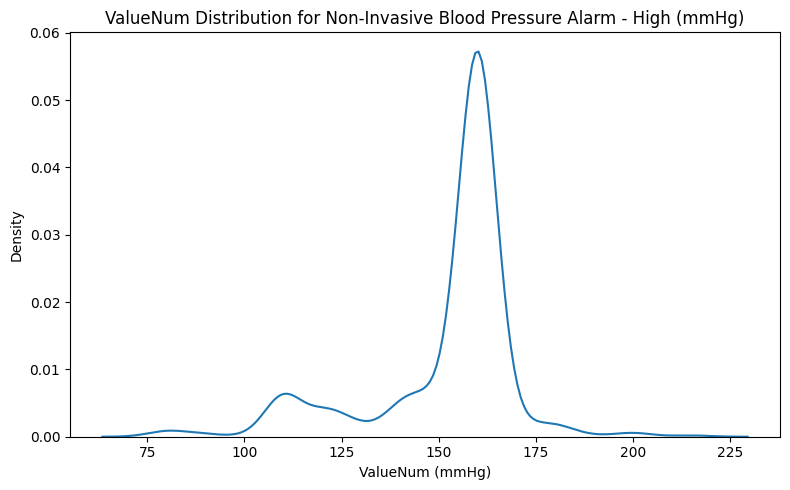

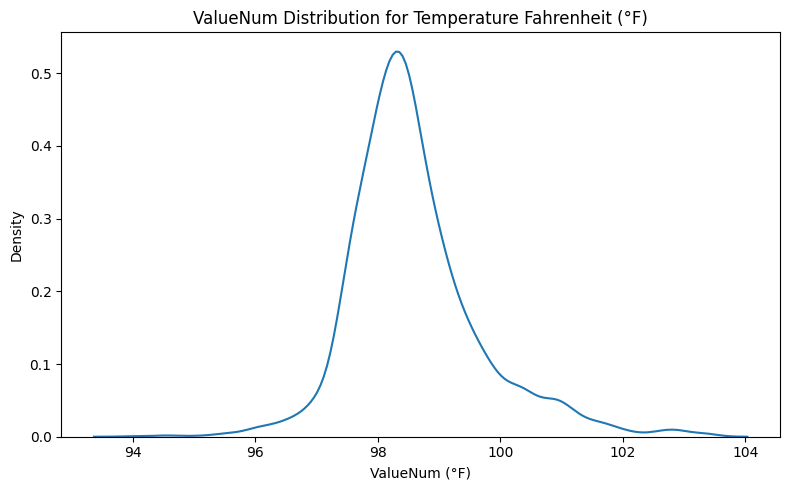

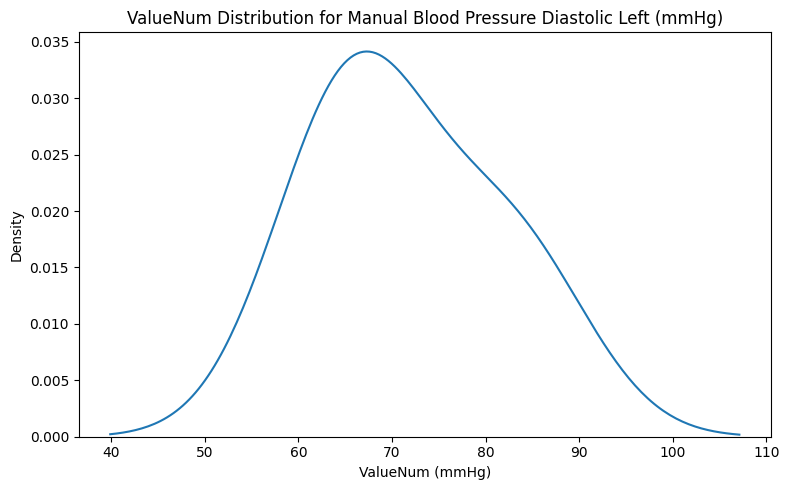

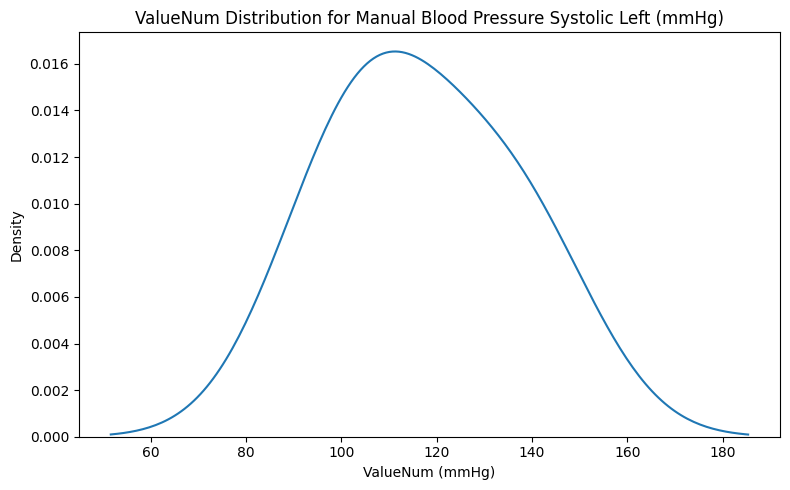

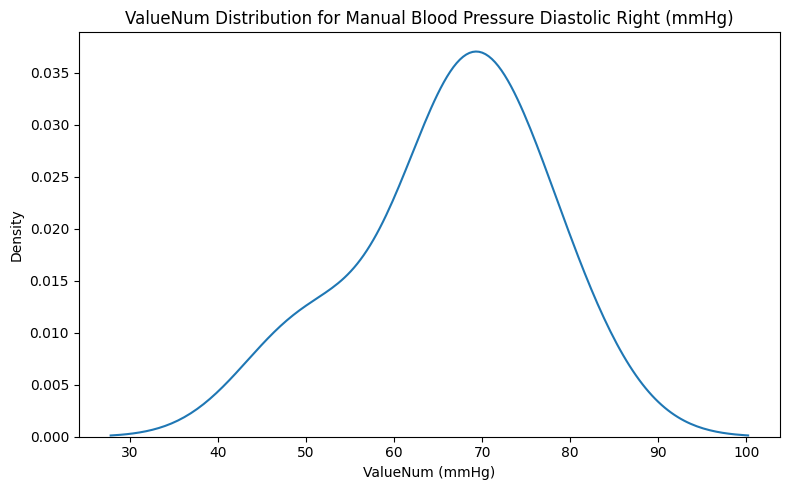

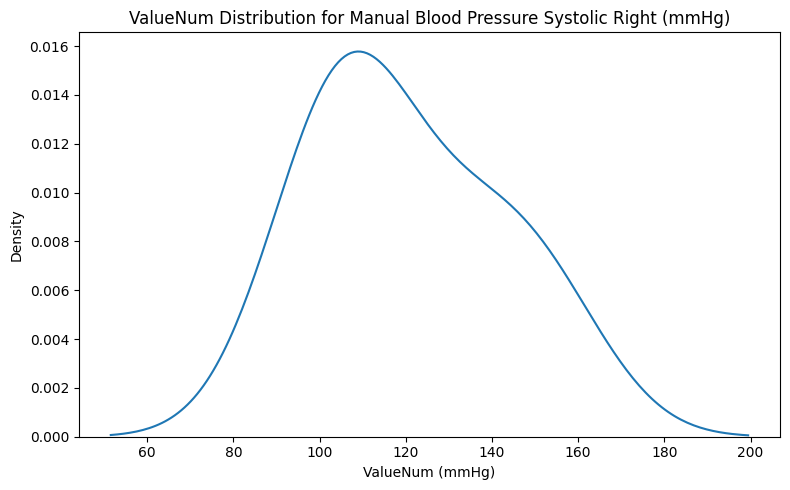

/tmp/ipykernel_2745731/2888883709.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['valuenum'])


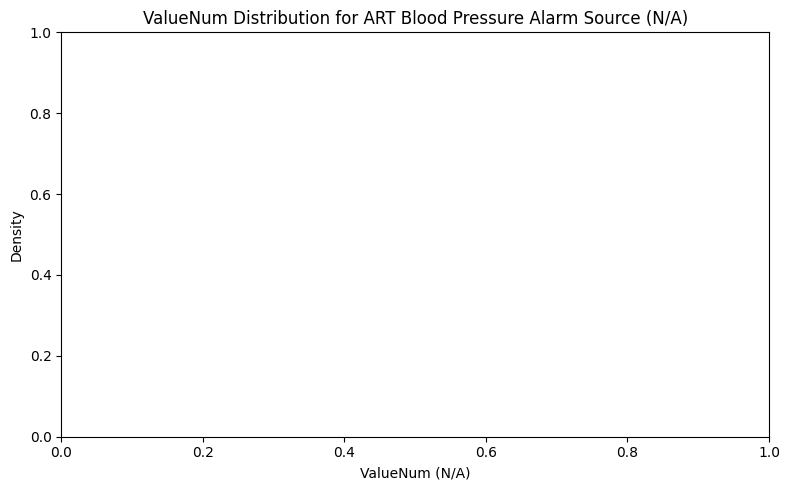

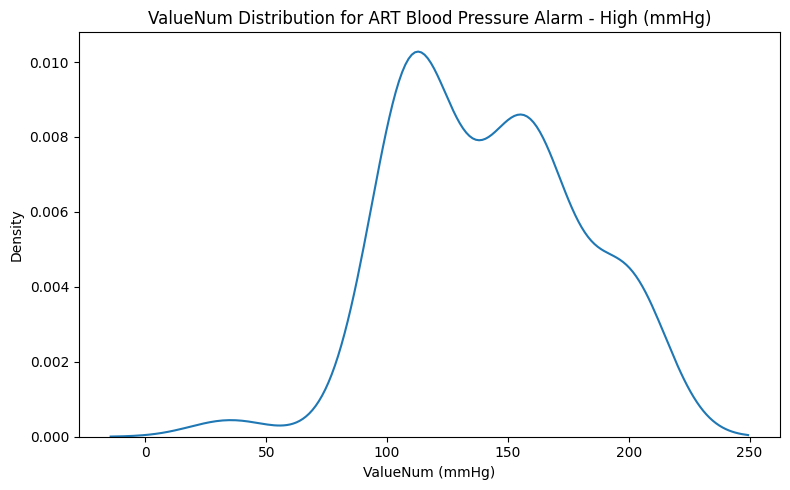

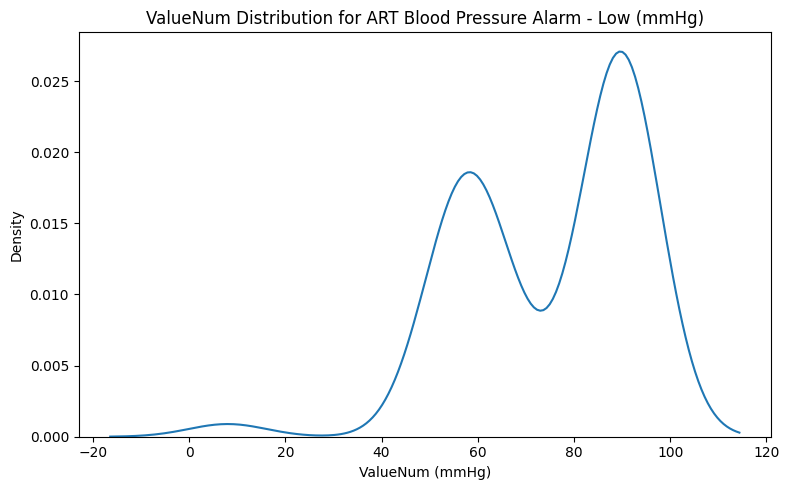

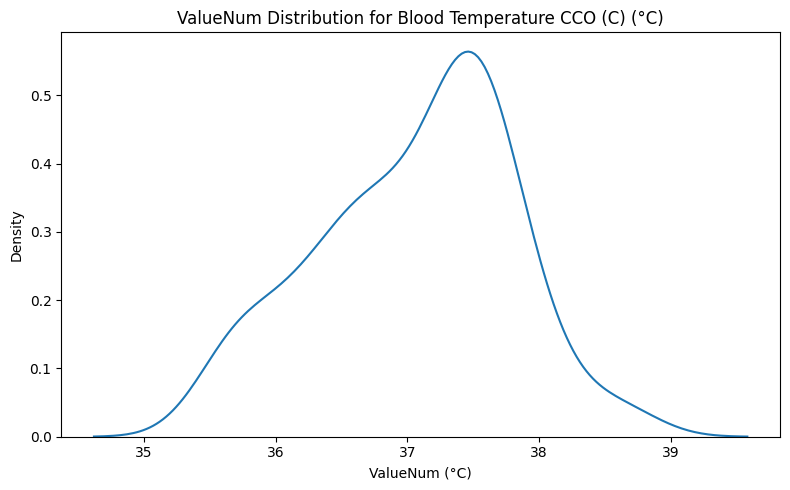

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for label in vitals_data['label'].unique():
    subset = vitals_data[vitals_data['label'] == label]
    plt.figure(figsize=(8, 5))
    sns.kdeplot(subset['valuenum'])
    valueuom = subset['valueuom'].iloc[0] if 'valueuom' in subset.columns and not subset['valueuom'].isnull().all() else 'N/A'
    plt.title(f'ValueNum Distribution for {label} ({valueuom})')
    plt.xlabel(f'ValueNum ({valueuom})')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

#Data Pre-processing

In [ ]:
# Pivot the data so that each label becomes a separate column
vitals_pivot = vitals_data.pivot_table(index=['subject_id', 'hadm_id'], columns='label', values='valuenum', aggfunc='mean').reset_index()

# Merge with demographic features (gender, anchor_age, admission_type)
demographics = vitals_data[['subject_id', 'hadm_id', 'gender', 'anchor_age', 'admission_type']].drop_duplicates()
vitals_data = pd.merge(vitals_pivot, demographics, on=['subject_id', 'hadm_id'], how='left')

In [ ]:
print(vitals_data['gender'].unique())

['F' 'M']


In [ ]:
print(vitals_data['admission_type'].unique())

['EW EMER.' 'DIRECT EMER.' 'URGENT' 'SURGICAL SAME DAY ADMISSION'
 'OBSERVATION ADMIT' 'ELECTIVE']


In [ ]:
from sklearn.preprocessing import LabelEncoder

#label Encoding for categorical columns
label_encoder = LabelEncoder()
vitals_data['admission_type'] = label_encoder.fit_transform(vitals_data['admission_type'])
vitals_data['gender'] = label_encoder.fit_transform(vitals_data['gender'])

We prefer label encoder rather than one hot encoding since we have have multiple categories in vitals_data['admission_type'] rather than binary values that can be categorized in 0 or 1 like in vitals_data['gender'].

In [ ]:
vitals_data

,subject_id,hadm_id,ART Blood Pressure Alarm - High,ART Blood Pressure Alarm - Low,Arterial Blood Pressure Alarm - High,Arterial Blood Pressure Alarm - Low,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,Blood Temperature CCO (C),...,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Non-Invasive Blood Pressure Alarm - High,Non-Invasive Blood Pressure Alarm - Low,Temperature Celsius,Temperature Fahrenheit,gender,anchor_age,admission_type
0,10000032,29079034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54.100000,62.300000,88.900000,160.000000,82.500000,NaN,98.966667,0,52,2
1,10001217,24597018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.333333,93.500000,136.296296,150.000000,90.000000,NaN,99.066667,0,55,2
2,10001217,27703517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.478261,83.217391,115.869565,150.000000,90.000000,NaN,98.133333,0,55,0
3,10001725,25563031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.187500,70.062500,100.406250,160.000000,90.000000,NaN,97.900000,0,46,2
4,10002428,20321825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.978723,63.127660,100.000000,160.000000,90.000000,NaN,98.453846,0,80,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,10039708,24928679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.722222,76.722222,108.833333,160.000000,90.000000,NaN,98.444444,0,46,3
124,10039708,28258130,180.0,90.0,112.5,65.909091,62.060403,76.870536,95.460850,NaN,...,64.048000,70.374502,92.224000,126.111111,72.222222,NaN,97.437594,0,46,2
125,10039831,26924951,NaN,NaN,160.0,93.333333,55.918919,77.621622,117.891892,NaN,...,62.000000,NaN,133.000000,160.000000,110.000000,NaN,99.808333,0,57,4
126,10039997,24294180,160.0,90.0,145.0,113.333333,65.642857,91.142857,141.250000,NaN,...,85.000000,100.375000,148.125000,160.000000,90.000000,NaN,98.500000,0,67,4


In [ ]:
vitals_data.dtypes

subject_id                                    int64
hadm_id                                       int64
ART Blood Pressure Alarm - High             float64
ART Blood Pressure Alarm - Low              float64
Arterial Blood Pressure Alarm - High        float64
Arterial Blood Pressure Alarm - Low         float64
Arterial Blood Pressure diastolic           float64
Arterial Blood Pressure mean                float64
Arterial Blood Pressure systolic            float64
Blood Temperature CCO (C)                   float64
Heart Rate                                  float64
Heart Rate Alarm - Low                      float64
Heart rate Alarm - High                     float64
Manual Blood Pressure Diastolic Left        float64
Manual Blood Pressure Diastolic Right       float64
Manual Blood Pressure Systolic Left         float64
Manual Blood Pressure Systolic Right        float64
Non Invasive Blood Pressure diastolic       float64
Non Invasive Blood Pressure mean            float64
Non Invasive

Now we deal with the missing values. We first drop columns that have more than 10% missing values, and then impute the other columns with missing values.

In [ ]:
#calculate missing percentage for each column
missing_percentage = vitals_data.isnull().mean() * 100

missing_values = vitals_data.isnull().sum()
print("Missing Values before dropping columns:")
print(missing_values)

#drop columns with more than 10% missing values
columns_to_drop = missing_percentage[missing_percentage > 10].index
print("Columns to drop: ", columns_to_drop)
vitals_data.drop(columns=columns_to_drop, inplace=True)


#print missing values before imputation
missing_values = vitals_data.isnull().sum()
print("Missing Values after dropping columns:")
print(missing_values)

#impute columns with less than 10% missing values using median
imputer = SimpleImputer(strategy='median')
numerical_columns = vitals_data.select_dtypes(include=['float64', 'int64']).columns
vitals_data[numerical_columns] = imputer.fit_transform(vitals_data[numerical_columns])

#print missing values after imputation
missing_values = vitals_data.isnull().sum()
print("Missing Values after Imputation:")
print(missing_values)


Missing Values before dropping columns:
subject_id                                    0
hadm_id                                       0
ART Blood Pressure Alarm - High             106
ART Blood Pressure Alarm - Low              106
Arterial Blood Pressure Alarm - High         63
Arterial Blood Pressure Alarm - Low          63
Arterial Blood Pressure diastolic            64
Arterial Blood Pressure mean                 64
Arterial Blood Pressure systolic             64
Blood Temperature CCO (C)                   124
Heart Rate                                    0
Heart Rate Alarm - Low                        0
Heart rate Alarm - High                       0
Manual Blood Pressure Diastolic Left        125
Manual Blood Pressure Diastolic Right       124
Manual Blood Pressure Systolic Left         125
Manual Blood Pressure Systolic Right        124
Non Invasive Blood Pressure diastolic         0
Non Invasive Blood Pressure mean              1
Non Invasive Blood Pressure systolic          0


In [ ]:
vitals_data

,subject_id,hadm_id,ART Blood Pressure Alarm - High,ART Blood Pressure Alarm - Low,Arterial Blood Pressure Alarm - High,Arterial Blood Pressure Alarm - Low,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,Blood Temperature CCO (C),...,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,Non-Invasive Blood Pressure Alarm - High,Non-Invasive Blood Pressure Alarm - Low,Temperature Celsius,Temperature Fahrenheit,gender,anchor_age,admission_type
0,10000032,29079034,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,54.100000,62.300000,88.900000,160.000000,82.500000,36.426923,98.966667,0,52,2
1,10001217,24597018,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,81.333333,93.500000,136.296296,150.000000,90.000000,36.426923,99.066667,0,55,2
2,10001217,27703517,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,73.478261,83.217391,115.869565,150.000000,90.000000,36.426923,98.133333,0,55,0
3,10001725,25563031,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,61.187500,70.062500,100.406250,160.000000,90.000000,36.426923,97.900000,0,46,2
4,10002428,20321825,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,51.978723,63.127660,100.000000,160.000000,90.000000,36.426923,98.453846,0,80,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,10039708,24928679,137.5,77.5,140.0,87.000000,58.309211,78.341515,115.885979,37.080823,...,62.722222,76.722222,108.833333,160.000000,90.000000,36.426923,98.444444,0,46,3
124,10039708,28258130,180.0,90.0,112.5,65.909091,62.060403,76.870536,95.460850,37.080823,...,64.048000,70.374502,92.224000,126.111111,72.222222,36.426923,97.437594,0,46,2
125,10039831,26924951,137.5,77.5,160.0,93.333333,55.918919,77.621622,117.891892,37.080823,...,62.000000,75.956989,133.000000,160.000000,110.000000,36.426923,99.808333,0,57,4
126,10039997,24294180,160.0,90.0,145.0,113.333333,65.642857,91.142857,141.250000,37.080823,...,85.000000,100.375000,148.125000,160.000000,90.000000,36.426923,98.500000,0,67,4


In [ ]:
#scale numerical features
scaler = StandardScaler()
numerical_columns = vitals_data.select_dtypes(include=['float64', 'int64']).columns
vitals_data[numerical_columns] = scaler.fit_transform(vitals_data[numerical_columns])

print(vitals_data)

     subject_id   hadm_id  Heart Rate  Heart Rate Alarm - Low  \
0     -1.700432  1.326466    0.630292                0.036343   
1     -1.592244 -0.186975    0.384416                0.036343   
2     -1.592244  0.861996   -0.666737                0.036343   
3     -1.545865  0.139219   -0.700793               -0.020961   
4     -1.481683 -1.630578    0.754810                0.036343   
..          ...       ...         ...                     ...   
123    1.921880 -0.074983   -1.046635               -0.192871   
124    1.921880  1.049272   -0.595663               -0.185925   
125    1.933110  0.599098    0.791461               -0.040062   
126    1.948265 -0.289234    0.470025               -0.040062   
127    1.950822  0.960849   -0.022859               -0.175239   

     Heart rate Alarm - High  Non Invasive Blood Pressure diastolic  \
0                  -0.554635                              -1.042478   
1                  -0.554635                               1.807864   
2     

##Correlation Matrix

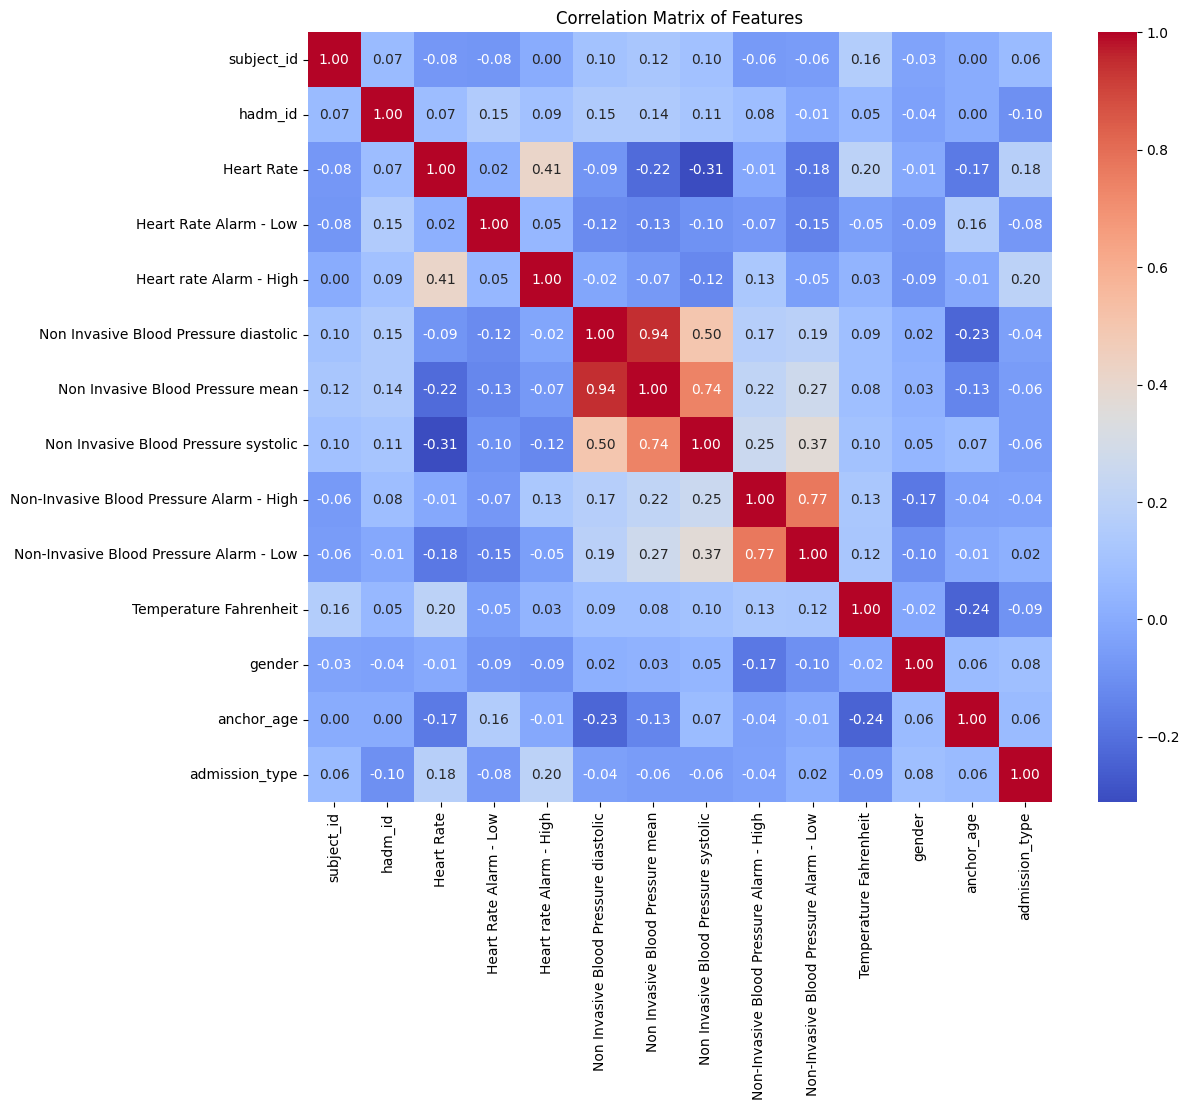

In [ ]:
# Correlation Matrix of Features
correlation_matrix = vitals_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

We can see some correlation in above matrix as to how Non invasive blood pressure Alarm High and Low are highly correlated to each other.Similarly the Non invasive blood pressure mean is correlated with its diastolic and systolic pressure. We can also see that Heart rate and Non invasive systolic pressure has highest negative correlation with each other.

#K-Means Clustering

In [ ]:
#perform K-Means clustering with multiple models and hyperparameter tuning
from sklearn.metrics import silhouette_score

#hyperparameters to test
k_values = range(2, 10)  #number of clusters to evaluate
init_methods = ['k-means++', 'random']  #initialization methods
max_iter_values = [300, 500]  #maximum iterations
distortions = []
silhouettes = []
best_silhouette = -1

for init_method in init_methods:
    for max_iter in max_iter_values:
        for k in k_values:
            kmeans = KMeans(n_clusters=k, init=init_method, max_iter=max_iter, random_state=42)
            clusters = kmeans.fit_predict(vitals_data)
            distortion = kmeans.inertia_
            silhouette = silhouette_score(vitals_data, clusters)

            distortions.append((k, init_method, max_iter, distortion))
            silhouettes.append((k, init_method, max_iter, silhouette))

            print(f"Model with k={k}, init_method={init_method}, max_iter={max_iter} -> "
                  f"Distortion: {distortion:.2f}, Silhouette: {silhouette:.2f}")

            if silhouette > best_silhouette:
                best_model = kmeans
                best_silhouette = silhouette
                best_k = k
                best_init = init_method


Model with k=2, init_method=k-means++, max_iter=300 -> Distortion: 1560.54, Silhouette: 0.11
Model with k=3, init_method=k-means++, max_iter=300 -> Distortion: 1449.12, Silhouette: 0.09
Model with k=4, init_method=k-means++, max_iter=300 -> Distortion: 1369.49, Silhouette: 0.08
Model with k=5, init_method=k-means++, max_iter=300 -> Distortion: 1321.85, Silhouette: 0.08
Model with k=6, init_method=k-means++, max_iter=300 -> Distortion: 1207.85, Silhouette: 0.07
Model with k=7, init_method=k-means++, max_iter=300 -> Distortion: 1068.29, Silhouette: 0.08
Model with k=8, init_method=k-means++, max_iter=300 -> Distortion: 1002.08, Silhouette: 0.10
Model with k=9, init_method=k-means++, max_iter=300 -> Distortion: 962.85, Silhouette: 0.11
Model with k=2, init_method=k-means++, max_iter=500 -> Distortion: 1560.54, Silhouette: 0.11
Model with k=3, init_method=k-means++, max_iter=500 -> Distortion: 1449.12, Silhouette: 0.09
Model with k=4, init_method=k-means++, max_iter=500 -> Distortion: 1369

##Evaluation

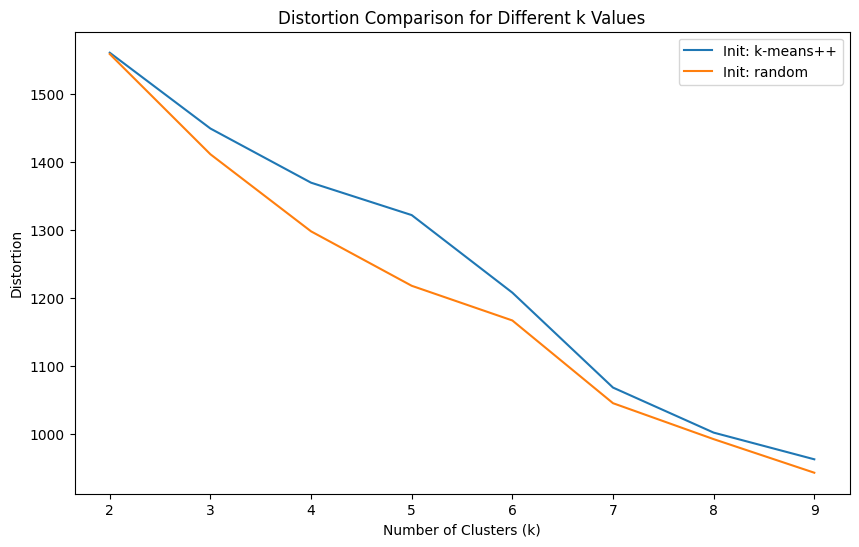

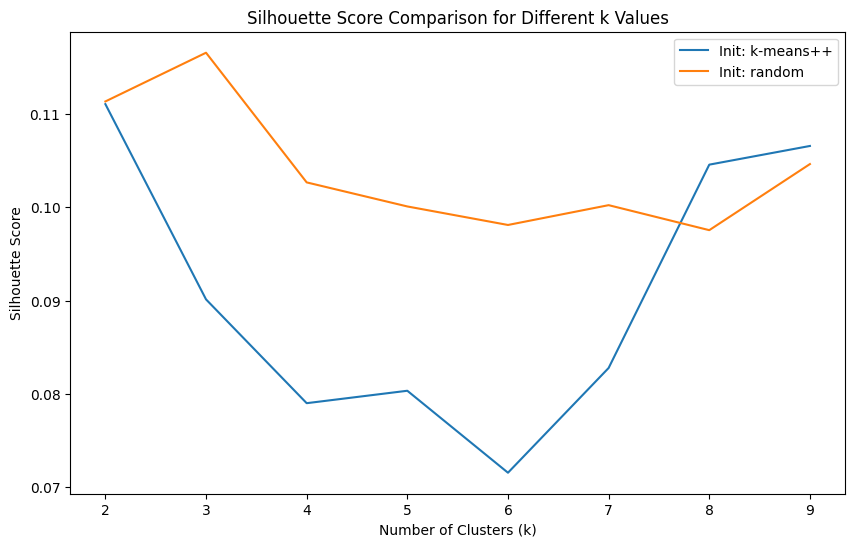

In [ ]:
#convert distortions and silhouettes to DataFrames for visualization
distortions_df = pd.DataFrame(distortions, columns=['k', 'init_method', 'max_iter', 'distortion'])
silhouettes_df = pd.DataFrame(silhouettes, columns=['k', 'init_method', 'max_iter', 'silhouette'])

#plot distortion for different k values
plt.figure(figsize=(10, 6))
for init_method in init_methods:
    subset = distortions_df[(distortions_df['init_method'] == init_method) & (distortions_df['max_iter'] == 300)]
    plt.plot(subset['k'], subset['distortion'], label=f'Init: {init_method}')
plt.title('Distortion Comparison for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.legend()
plt.show()

#plot silhouette score for different k values
plt.figure(figsize=(10, 6))
for init_method in init_methods:
    subset = silhouettes_df[(silhouettes_df['init_method'] == init_method) & (silhouettes_df['max_iter'] == 300)]
    plt.plot(subset['k'], subset['silhouette'], label=f'Init: {init_method}')
plt.title('Silhouette Score Comparison for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

In [ ]:
print(best_model)

# Update the dataset with the best clustering
vitals_data['cluster'] = best_model.labels_

KMeans(init='random', n_clusters=3, random_state=42)


From the above graphs we can see that hyperparameters KMeans(init='random', n_clusters=3, random_state=42) give best silhoute score. Although we can also see how the distortion starts decreasing as the number of clusters increase. As higher clusters reduces the distortion noise among data points, giving more fine grained clusters.

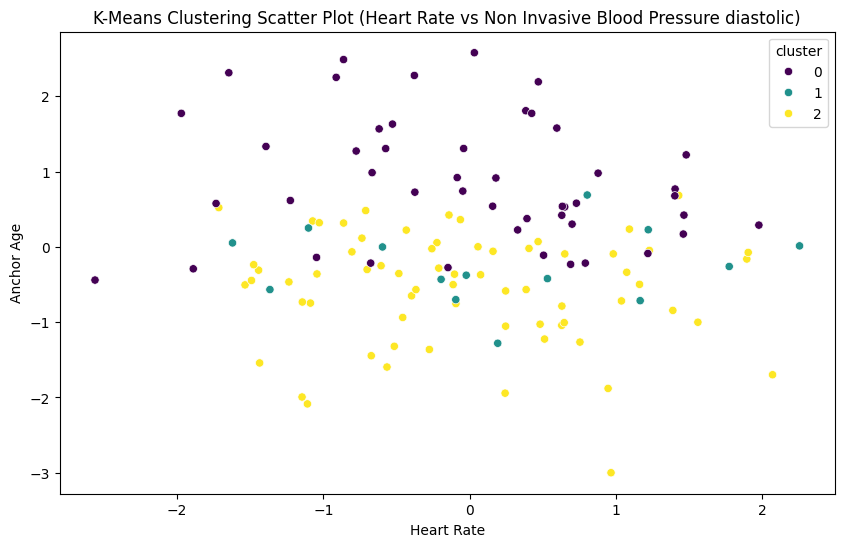

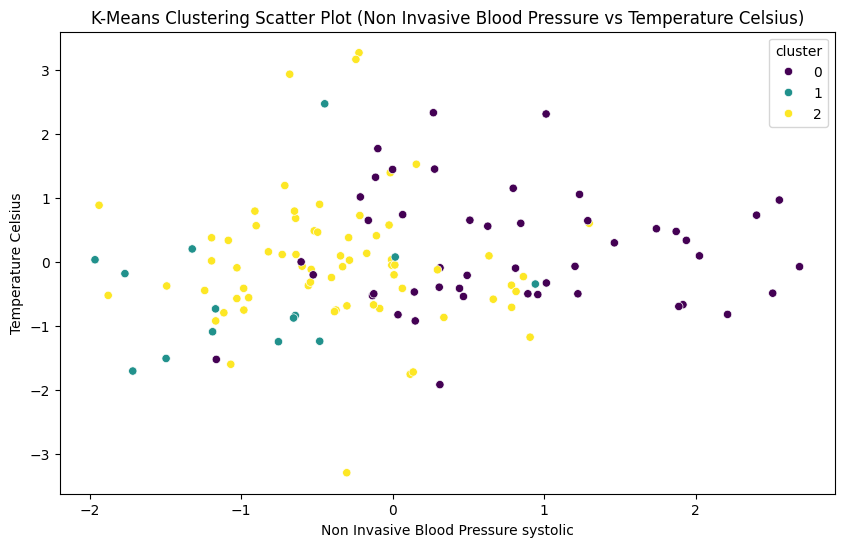

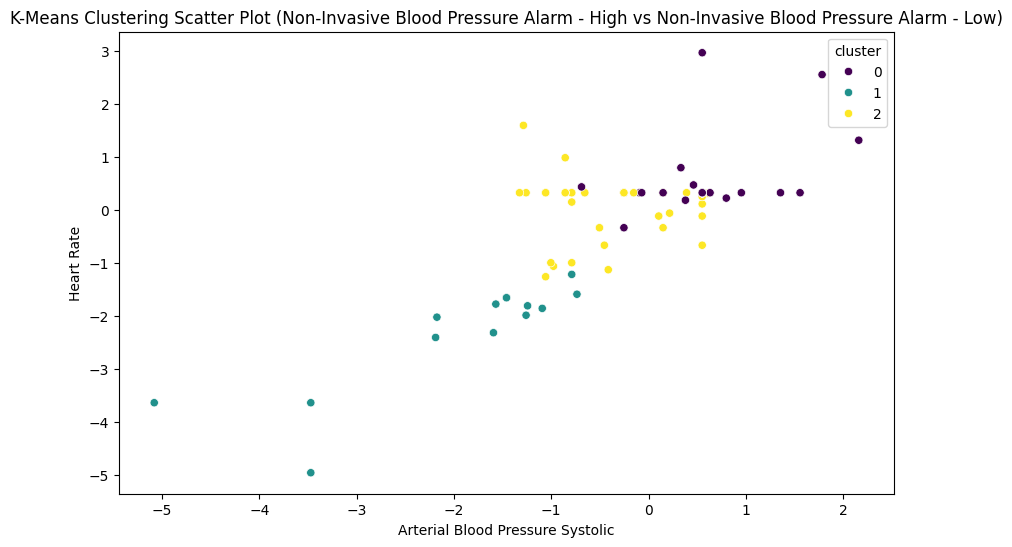

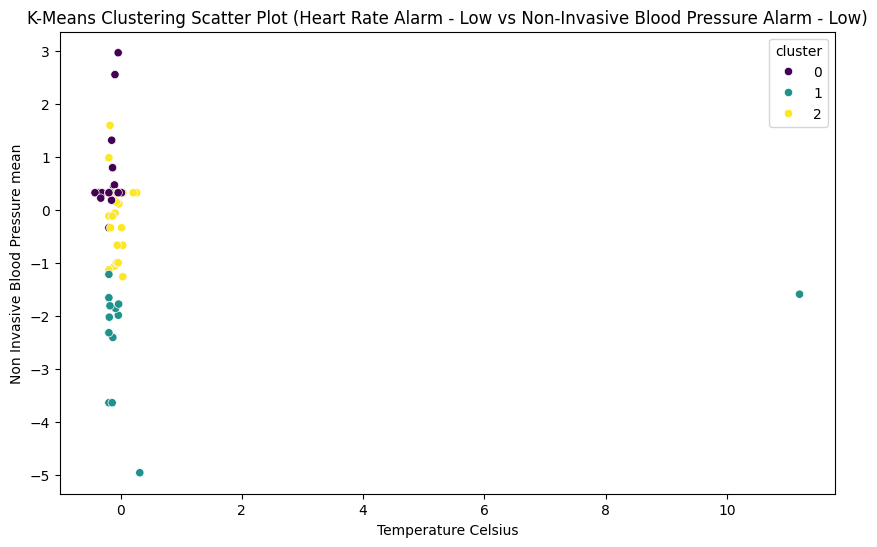

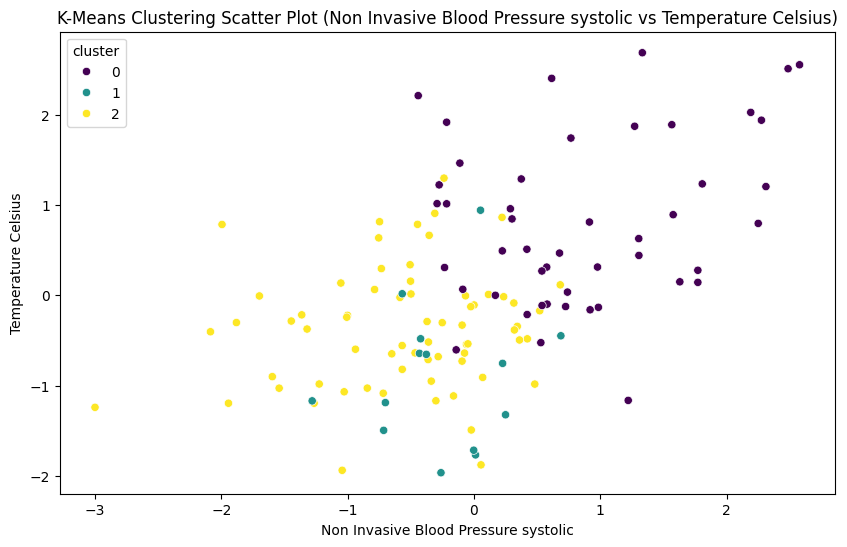

In [ ]:
# Visualize K-Means Clustering using scatter plots for relevant feature pairs
# Scatter Plot 1: Heart Rate vs Non Invasive Blood Pressure diastolic
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Heart Rate', y='Non Invasive Blood Pressure diastolic', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Heart Rate vs Non Invasive Blood Pressure diastolic)')
plt.xlabel('Heart Rate')
plt.ylabel('Anchor Age')
plt.show()

# Scatter Plot 2: Non Invasive Blood Pressure systolic vs Temperature Celsius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Non Invasive Blood Pressure systolic', y='Temperature Fahrenheit', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Non Invasive Blood Pressure vs Temperature Celsius)')
plt.xlabel('Non Invasive Blood Pressure systolic')
plt.ylabel('Temperature Celsius')
plt.show()

# Scatter Plot 3: Non-Invasive Blood Pressure Alarm - High vs Non-Invasive Blood Pressure Alarm - Low
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Non-Invasive Blood Pressure Alarm - High', y='Non-Invasive Blood Pressure Alarm - Low', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Non-Invasive Blood Pressure Alarm - High vs Non-Invasive Blood Pressure Alarm - Low)')
plt.xlabel('Arterial Blood Pressure Systolic')
plt.ylabel('Heart Rate')
plt.show()

# Scatter Plot 4: Heart Rate Alarm - Low vs Non-Invasive Blood Pressure Alarm - Low
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Heart Rate Alarm - Low', y='Non-Invasive Blood Pressure Alarm - Low', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Heart Rate Alarm - Low vs Non-Invasive Blood Pressure Alarm - Low)')
plt.xlabel('Temperature Celsius')
plt.ylabel('Non Invasive Blood Pressure mean')
plt.show()

# Scatter Plot 2: Non Invasive Blood Pressure systolic vs Temperature Celsius
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='Non Invasive Blood Pressure diastolic', y='Non Invasive Blood Pressure systolic', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Scatter Plot (Non Invasive Blood Pressure systolic vs Temperature Celsius)')
plt.xlabel('Non Invasive Blood Pressure systolic')
plt.ylabel('Temperature Celsius')
plt.show()

We perform different k-means clustering models and perform hyperparaneter tuning. We do evaluation via silhoute score comparison. But in kmeans when we compare different features the overlap between clusters is more, this might due to the variance might be less. This visualization might not be highly informative but still can show some degree of separation in high quality data. Hence we choose to rely more on PCA as it's better to visualize clusters on overall data over two axis (two principal components), and also reduces dimensionality while retaining maximum variance.

#PCA

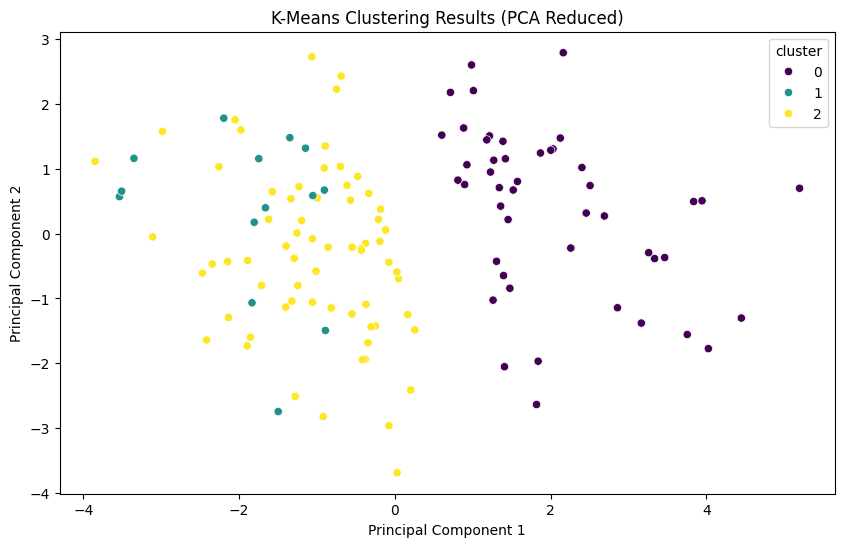

In [ ]:
from sklearn.decomposition import PCA

# Visualize Clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(vitals_data)
vitals_data['pca1'] = principal_components[:, 0]
vitals_data['pca2'] = principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=vitals_data, x='pca1', y='pca2', hue='cluster', palette='viridis')
plt.title('K-Means Clustering Results (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()